In [39]:
from ts_vae.data_processors.ts_gen_processor import TSGenDataset
from torch_geometric.data import DataLoader
import torch
import numpy as np
from ts_vae.utils import remove_files
remove_files() 
rxns = TSGenDataset(r'data')
rxns[0]
###
tt_split = 0.889
num_rxns = len(rxns)
num_train = int(np.floor(tt_split * num_rxns))
batch_size = 2
train_loader = DataLoader(rxns[: num_train], batch_size = batch_size)
test_loader = DataLoader(rxns[num_train: ], batch_size = batch_size)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#for inputs in train_loader:
#    inputs = inputs.to(device)
###
batch = next(iter(train_loader))
test = batch.edge_attr

In [44]:
test_loader.dataset[9].pos

tensor([[ 1.051,  1.305, -0.337],
        [-1.183,  0.459,  0.064],
        [-0.972, -0.777, -0.083],
        [ 0.377, -0.775,  0.377],
        [ 1.268,  0.150,  0.004],
        [-1.334,  1.494,  0.275],
        [-1.491, -1.678, -0.370],
        [ 2.294, -0.242,  0.067],
        [ 0.000,  0.000,  0.000],
        [ 0.000,  0.000,  0.000],
        [ 0.000,  0.000,  0.000],
        [ 0.000,  0.000,  0.000],
        [ 0.000,  0.000,  0.000],
        [ 0.000,  0.000,  0.000],
        [ 0.000,  0.000,  0.000],
        [ 0.000,  0.000,  0.000],
        [ 0.000,  0.000,  0.000],
        [ 0.000,  0.000,  0.000],
        [ 0.000,  0.000,  0.000],
        [ 0.000,  0.000,  0.000],
        [ 0.000,  0.000,  0.000]])

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
from experiments.building_on_mit.meta_eval.meta_eval import ablation_experiment
# from ts_vae.utils import remove_files
# remove_files()
train_log, test_log = ablation_experiment(tt_split = 0.889, epochs = 1, test_interval = 1, \
                                          batch_size = 8, h_nf = 20, n_layers = 1, gnn_depth = 1)

# full params for 20 epochs, ran everything, took 2500s, test_interval=2 worked first time not on second; ~2m for each epoch

# tt_split=0.889, gives 842 test rxns

# 1 was my d_gt but was wrong! got it from lucky's and was right
# gnn + dw, no recon, train on DS: e=10,b=32,h/n/g=standard
#   - just init: 
#       2,3 --> one peak at ~7.5
#   - init + gnn w node: e=10-time=90s; e=20, time=180s
#       6 --> one enormous peak at ~7.5, extremely similar matrices
#       7 --> more of a distr but weird
#       8 --> e=20: much better shape (bimodal) but shifted to 5-7.5 # NOTE: messed this up and made 38
#       9 --> e=20: back to enormous peak at ~7.5
#   - init + gnn w edge: e=10-time=200s
#      10 --> time=200s: bimodal but v flat and wide from 1-8A, matrices more different
#      11 --> e=20-time=400s: trimodal (two big one small) from around 4-10A # NOTE: messed this up and made 38
#      12 --> b=8-time=260s: trimodal (two big one small) from around 4-10A
#      notes: this change causes more diff matrices and bimodality
#   - init + gnn w edge, node
#       4,5 --> more bimodal (like gt), bigger peak ~6.5, smaller peak ~8.7
#       13 --> time=290s: unimodal ~1 (much nearer GT) but long low tail to 8A
#       14 --> b=8-time=380s: unimodal ~5.8, low and flat, gaussian-looking
#       15 --> b=8,e=20-time=760s: similar to 14 but more bimodal (and weird)
#   - other notes: training decreasing from ~5.3 -> ~3.7
# gnn + dw + recon no opt, train on DX: e=10,b=8,h/n/g=standard
#   - gram + low rank, no opt: 
#       16 --> flat like a uniform from 3-7A
#       17 --> unimodal ~4A from 2-6A, matrices looking double what they should be
#       with only f_i not f_j: bottom triangle is double
#       without symmetrise, all elements in matrix are v similar
#       trying with -2 in d_init_const
#       18 --> e=20-time=1000s: with -2 d_init_const, unimodal produced results ~3.5A
#       19 --> e=20-time= : with -3 d_init_const, v similar matrices
# gnn + dw + recon no opt, train on RMSD: e=20,b=8,h/n/g=standard
#       20 --> same as 19 with diff loss and -2.5 const but getting more differences in matrix [am i?]
#       21 --> e=10 but same as 20 w -2 const, better range ~1.5-2.5A but unimodal, v similar matrices
#       22 --> e=10 but same as 2- w -2.25 const, range ~2.5-3A and unimodal-ish, v similar matrices
#       23 --> time=1100s: -3 const, far too small
#       24 --> e=10-time=530s: unimodal ~3A from 2-5A
#       25 --> const -2.3: unimodal ~2A from 1.5-2.5A
#   - no symmetrise
#       26 --> e=10: 500s, no softplus, no constant, unimodal w v big peak at ~3A, all the same values in matrices
#       27 --> e=10, softplus but no constant
#       28 --> e=10, 500s: const -2.3 unimodal ~3, range from 1-5-5A
#       28 --> e=10, 500s: const -2.5, same as above basically
#       29 --> e=10, 500s: add symmetrise and it got weird
#   - other notes: training decreasing from ~2.1 -> ~1.7, when sorting out DW layer, goes from ~1.9 -> ~1.55
#   - [change to better GPU]
#       30 --> e=10, 360s: remove d_init_const and replace with linear layer instead
#       31 --> e=10, 360s: one more linear layer, minimal diff
#       32 --> e=20, 740s: same params as 30 but w more epochs, got stuck from e5->e20
#       33 --> same: unimodal ~3A from 2-4.5A, bit bumpy,matrices ended getting smoothed out
#       34 --> back to e=10 + 3 LL to avoid smoothing: they are diff but scaled down massively... have to multiply D_init by 500
#       35 --> same but no softplus on D: super wrong, gets negative
#       36 --> e=10 w 2 LL + softplus (i.e. standard): unimodal ~3 but slightly better shape 
# gnn + dw + recon w opt: train on RMSD: e=10, others standard
#   - t=25
#       36 --> v small, bimodal but wrong way round and not in one curve 
#       37 --> 3 LL, 746s: everything was zero
#       38 --> t=50, time - 20s, no bimodality
#       39 --> 950s: remove alpha base




Starting ablation experiment...
===== Training epoch 001 complete with loss: 2.0361 ====
===== Testing epoch 001 complete with loss: 1.9808 ====
Completed ablation experiment, use the experiment log to print results.


In [37]:
file_name = 'd_gt.npy'

Len of each list pre removing zeros: 153968 153968 153968 153968 
Len of each list post removing zeros: 4346 4346 4346 4346 


C:\Users\Avish\miniconda3\envs\3d-rdkit\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Avish\miniconda3\envs\3d-rdkit\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Avish\miniconda3\envs\3d-rdkit\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

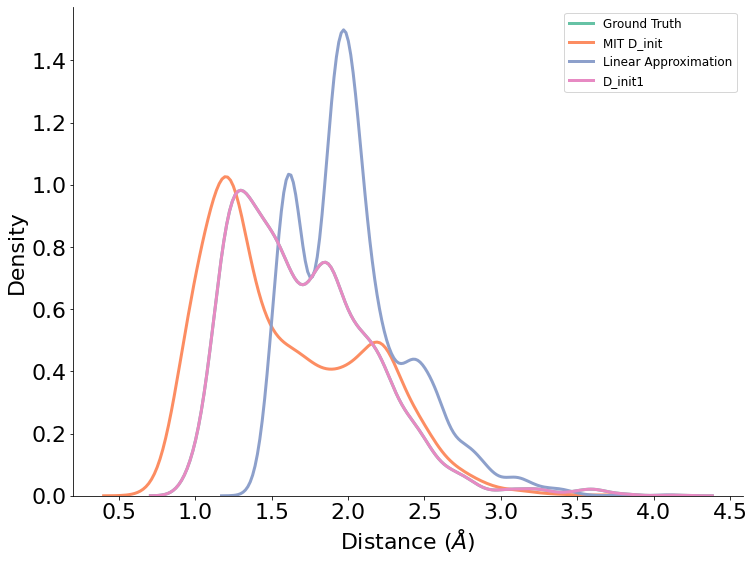

In [38]:
from rdkit import Chem
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

base_folder = r'data/raw/' # normal
test_ts_file = base_folder + 'test_ts.sdf'
reactant_file = base_folder + 'test_reactants.sdf'
product_file = base_folder + 'test_products.sdf'
test_r = Chem.SDMolSupplier(reactant_file, removeHs=False, sanitize=False)
test_r = [x for x in test_r]
test_ts = Chem.SDMolSupplier(test_ts_file, removeHs=False, sanitize=False)
test_ts = [ts for ts in test_ts]
test_p = Chem.SDMolSupplier(product_file, removeHs=False, sanitize=False)
test_p = [x for x  in test_p]

# want to create a D_init of [num_train, 21, 21] for plotting
#batched_test_Ds = test_log.epoch_ae_results[-1]['D_gt']
#test_Ds = np.concatenate([D for D in batched_test_Ds], 0)

# save and load
d_folder = 'experiments/building_on_mit/meta_eval/d_inits/'
D_init = np.load(d_folder + 'mit_best.npy')
# np.save(d_folder + file_name, test_Ds)
D_init1 = np.load(d_folder + file_name)
d_inits = []
d_inits.append(D_init1)
num_d_inits = len(d_inits)


########


# lists for plotting
gt, best_init, lin_approx = [], [], []
d_init_lists = [[] for i in range(num_d_inits)]

for idx in range(len(test_ts)):

    # num_atoms + mask for reaction core
    num_atoms = test_ts[idx].GetNumAtoms()
    core_mask = (Chem.GetAdjacencyMatrix(test_p[idx]) + Chem.GetAdjacencyMatrix(test_r[idx])) == 1

    # main 3
    gt.append(np.ravel(Chem.Get3DDistanceMatrix(test_ts[idx]) * core_mask))
    best_init.append(np.ravel(D_init[idx][0:num_atoms, 0:num_atoms] * core_mask))
    lin_approx.append(np.ravel((Chem.Get3DDistanceMatrix(test_r[idx]) + Chem.Get3DDistanceMatrix(test_p[idx])) / 2 * core_mask))

    # other d_inits
    for j, d_init_list in enumerate(d_init_lists):
        d_init_lists[j].append(np.ravel(d_inits[j][idx][0:num_atoms, 0:num_atoms]*core_mask))

# NOTE: fine up to this point, all lengths match

# make plottable
all_ds = [gt, best_init, lin_approx, *d_init_lists]
all_ds = [np.concatenate(ds).ravel() for ds in all_ds]

# NOTE: fine up to this point, all lengths match

prezero_msg = f"Len of each list pre removing zeros: "
for ds in all_ds:
    prezero_msg += f"{len(ds)} "
print(prezero_msg)

all_ds = [ds[ds != 0] for ds in all_ds] # only keep non-zero values

postzero_msg = f"Len of each list post removing zeros: "
for ds in all_ds:
    postzero_msg += f"{len(ds)} "
print(postzero_msg)

ds_dict = {'gt': (all_ds[0], 'Ground Truth'), 'best_init': (all_ds[1], 'MIT D_init'),\
     'lin_approx': (all_ds[2], 'Linear Approximation')}
base_ds_counter = len(ds_dict)
for k in range(len(d_init_lists)):
    name = f'D_init{k+1}'
    ds_dict[name] = (all_ds[base_ds_counter + k], name)


########


fig, ax = plt.subplots(figsize=(12,9))

num_to_plot = len(ds_dict)
cols = sns.color_palette("Set2", num_to_plot)

# keys: 'gt', 'lin_approx', 'best_init', f'D_init{i}'
# no_print = ['lin_approx']

for i, key in enumerate(ds_dict.keys()):
    #if key in no_print:
    #    continue
    sns.distplot(ds_dict[key][0], color=cols[i], kde_kws={"lw": 3, "label": ds_dict[key][1]}, hist=False)

ax.legend(loc='upper right')
ax.legend(fontsize=12)
ax.set_ylabel('Density', fontsize=22)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True) 

plt.savefig('opt50.png', bbox_inches='tight')

In [34]:
type(Chem.Get3DDistanceMatrix(test_ts[i])), type(D_init1[i][0:num_atoms, 0:num_atoms])

(numpy.ndarray, numpy.ndarray)

In [36]:
print(D_init.shape, D_init1.shape)
np.set_printoptions(precision = 3, threshold = 5, edgeitems = 5, suppress = True)
i = 10
num_atoms = test_ts[i].GetNumAtoms()
# print("MIT: \n", D_init[i][0:num_atoms, 0:num_atoms])
print("Mine: \n", D_init1[i][0:num_atoms, 0:num_atoms])
print("GT: \n", Chem.Get3DDistanceMatrix(test_ts[i]))

(842, 21, 21) (842, 21, 21)
Mine: 
 [[ 0.01   1.927  6.569 10.64   6.283 ...  0.925  5.99  11.117  7.605
  17.858]
 [ 1.927  0.01   2.395  4.42   2.063 ...  3.684  2.518  5.115  5.006
   8.857]
 [ 6.569  2.395  0.01   2.264  4.064 ...  9.973  7.831  1.2    1.198
   5.041]
 [10.64   4.42   2.264  0.01   1.828 ... 15.898  6.923  4.686  4.685
   1.032]
 [ 6.283  2.063  4.064  1.828  0.01  ...  9.977  2.084  7.698  7.739
   4.341]
 ...
 [ 0.925  3.684  9.973 15.898  9.977 ...  0.01   7.137 13.724 11.842
  23.922]
 [ 5.99   2.518  7.831  6.923  2.084 ...  7.137  0.01  10.676 13.604
  10.21 ]
 [11.117  5.115  1.2    4.686  7.698 ... 13.724 10.676  0.01   3.248
   6.337]
 [ 7.605  5.006  1.198  4.685  7.739 ... 11.842 13.604  3.248  0.01
   8.529]
 [17.858  8.857  5.041  1.032  4.341 ... 23.922 10.21   6.337  8.529
   0.01 ]]
GT: 
 [[0.    1.385 2.561 3.26  2.505 ... 0.957 2.445 3.333 2.756 4.225]
 [1.385 0.    1.544 2.1   1.433 ... 1.917 1.584 2.259 2.235 2.974]
 [2.561 1.544 0.    1.501 2.0

In [9]:
# lists for plotting
gt, best_init, lin_approx = [], [], []
d_init_lists = [[] for i in range(num_d_inits)]

for idx in range(len(test_ts)):

    # num_atoms + mask for reaction core
    num_atoms = test_ts[idx].GetNumAtoms()
    core_mask = (Chem.GetAdjacencyMatrix(test_p[idx]) + Chem.GetAdjacencyMatrix(test_r[idx])) == 1

    # main 3
    gt.append(np.ravel(Chem.Get3DDistanceMatrix(test_ts[idx]) * core_mask))
    best_init.append(np.ravel(D_init[idx][0:num_atoms, 0:num_atoms] * core_mask))
    lin_approx.append(np.ravel((Chem.Get3DDistanceMatrix(test_r[idx]) + Chem.Get3DDistanceMatrix(test_p[idx])) / 2 * core_mask))

    # other d_inits
    for j, d_init_list in enumerate(d_init_lists):
        d_init_lists[j].append(np.ravel(d_inits[j][idx][0:num_atoms, 0:num_atoms]*core_mask))

# NOTE: fine up to this point, all lengths match

# make plottable
all_ds = [gt, best_init, lin_approx, *d_init_lists]
all_ds = [np.concatenate(ds).ravel() for ds in all_ds]

# NOTE: fine up to this point, all lengths match

prezero_msg = f"Len of each list pre removing zeros: "
for ds in all_ds:
    prezero_msg += f"{len(ds)} "
print(prezero_msg)

all_ds = [ds[ds != 0] for ds in all_ds] # only keep non-zero values

postzero_msg = f"Len of each list post removing zeros: "
for ds in all_ds:
    postzero_msg += f"{len(ds)} "
print(postzero_msg)

ds_dict = {'gt': (all_ds[0], 'Ground Truth'), 'best_init': (all_ds[1], 'MIT D_init'),\
     'lin_approx': (all_ds[2], 'Linear Approximation')}
base_ds_counter = len(ds_dict)
for k in range(len(d_init_lists)):
    name = f'D_init{k+1}'
    ds_dict[name] = (all_ds[base_ds_counter + k], name)

fig, ax = plt.subplots(figsize=(12,9))

num_to_plot = len(ds_dict)
cols = sns.color_palette("Set2", num_to_plot)

# keys: 'gt', 'lin_approx', 'best_init', f'D_init{i}'
# no_print = ['lin_approx']

for i, key in enumerate(ds_dict.keys()):
    #if key in no_print:
    #    continue
    sns.distplot(ds_dict[key][0], color=cols[i], kde_kws={"lw": 3, "label": ds_dict[key][1]}, hist=False)

ax.legend(loc='upper right')
ax.legend(fontsize=12)
ax.set_ylabel('Density', fontsize=22)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True) 

plt.savefig('init+node.png', bbox_inches='tight')

Len of each list pre removing zeros: 153968 153968 153968 153968 
Len of each list post removing zeros: 4346 4346 4346 4346 


C:\Users\Avish\miniconda3\envs\3d-rdkit\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Avish\miniconda3\envs\3d-rdkit\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Avish\miniconda3\envs\3d-rdkit\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

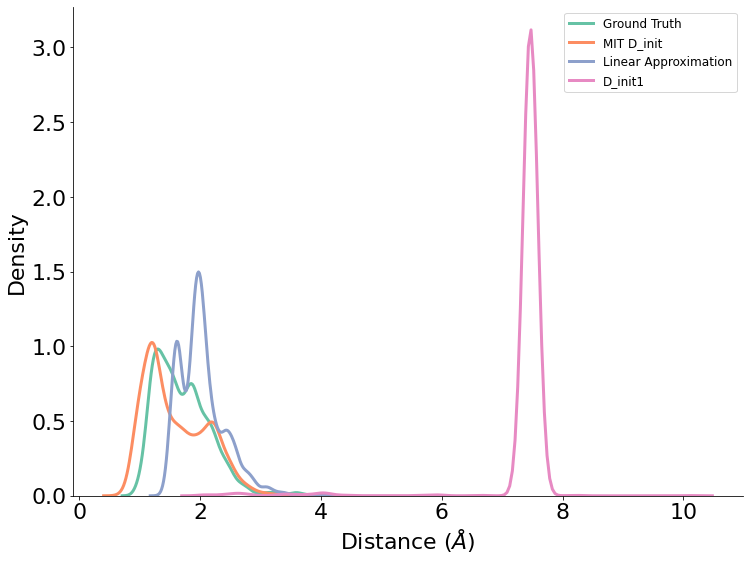

In [11]:
fig, ax = plt.subplots(figsize=(12,9))

num_to_plot = len(ds_dict)
cols = sns.color_palette("Set2", num_to_plot)

# keys: 'gt', 'lin_approx', 'best_init', f'D_init{i}'
# no_print = ['lin_approx']

for i, key in enumerate(ds_dict.keys()):
    #if key in no_print:
    #    continue
    sns.distplot(ds_dict[key][0], color=cols[i], kde_kws={"lw": 3, "label": ds_dict[key][1]}, hist=False)

ax.legend(loc='upper right')
ax.legend(fontsize=12)
ax.set_ylabel('Density', fontsize=22)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True) 

plt.savefig('init.png', bbox_inches='tight')

In [13]:
from rdkit import Chem
import torch

def get_euc_dist(X):
    D_sq = torch.square(torch.unsqueeze(X, 1) - torch.unsqueeze(X, 2))
    D = torch.sum(D_sq, 3) + 1e-2
    return D

def sequence_mask(sizes, max_size = 21, dtype = torch.bool, device = 'cpu'):
    row_vector = torch.arange(0, max_size, 1).to(device)
    matrix = torch.unsqueeze(sizes, dim = -1)
    mask = row_vector < matrix
    mask.type(dtype)
    return mask

def loss_dist(X_pred, X_gt, mask_D):
    D_pred = mask_D * get_euc_dist(X_pred)
    D_gt = mask_D * get_euc_dist(X_gt)
    loss_dist_all = mask_D * torch.abs(D_pred - D_gt)
    loss_dist = torch.sum(loss_dist_all) / torch.sum(mask_D)
    return loss_dist

i = 1
base_folder = r'data/raw/' # normal
test_ts_file = base_folder + 'test_ts.sdf'
test_ts = Chem.SDMolSupplier(test_ts_file, removeHs=False, sanitize=False)
test_ts = [ts for ts in test_ts]
num_atoms = test_ts[i].GetNumAtoms()
D_gt = torch.from_numpy(Chem.Get3DDistanceMatrix(test_ts[i]))

d_folder = 'experiments/building_on_mit/meta_eval/d_inits/'
D_init1 = np.load(d_folder + file_name)
D_pred = torch.from_numpy(D_init1[i][0:num_atoms, 0:num_atoms])

def loss_dist(D_pred, D_gt):
    loss_dist_all = torch.abs(D_pred - D_gt)
    loss_dist = torch.sum(loss_dist_all)
    return loss_dist

torch.set_printoptions(precision=3, threshold=5, edgeitems=4, sci_mode=None)
D_pred, D_gt, loss_dist(D_pred, D_gt)

(tensor([[0.000, 4.108, 4.350, 4.333,  ..., 2.453, 4.317, 4.281, 4.281],
         [3.954, 0.000, 2.483, 4.121,  ..., 4.013, 4.013, 4.015, 4.070],
         [4.373, 2.614, 0.000, 2.700,  ..., 4.384, 2.503, 2.504, 4.304],
         [4.344, 4.290, 2.692, 0.000,  ..., 4.346, 4.273, 4.268, 2.485],
         ...,
         [2.311, 3.979, 4.169, 4.144,  ..., 0.000, 4.088, 4.081, 4.061],
         [4.127, 3.980, 2.345, 4.074,  ..., 4.088, 0.000, 3.924, 4.031],
         [4.094, 3.983, 2.346, 4.070,  ..., 4.083, 3.924, 0.000, 4.060],
         [4.093, 4.036, 4.091, 2.335,  ..., 4.061, 4.031, 4.060, 0.000]]),
 tensor([[0.000, 1.775, 2.646, 3.076,  ..., 1.094, 3.608, 2.859, 3.026],
         [1.775, 0.000, 1.421, 2.458,  ..., 2.203, 2.038, 2.057, 2.624],
         [2.646, 1.421, 0.000, 1.516,  ..., 3.312, 1.095, 1.091, 2.235],
         [3.076, 2.458, 1.516, 0.000,  ..., 4.046, 2.122, 2.147, 1.110],
         ...,
         [1.094, 2.203, 3.312, 4.046,  ..., 0.000, 4.150, 3.392, 4.044],
         [3.608, 2.03

## Ensemble

Average all produced $D_{inits}s$ then plot.

In [82]:
ds_dict['D_init1'][0].shape, ds_dict['best_init'][0].shape

((4346,), (4346,))

In [83]:
# averaged ensemble of d_inits
ensemble_ds = []
d_inits
for i in range(len(ds_dict['best_init'][0])):
    ensemble_d = 0
    for j in range(1, num_d_inits + 1):
        ensemble_d += ds_dict[f'D_init{j}'][0][i]
    ensemble_d /= num_d_inits
    ensemble_ds.append(ensemble_d)

ds_dict['ens'] = (ensemble_ds, "Avg Ensemble D_init")

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

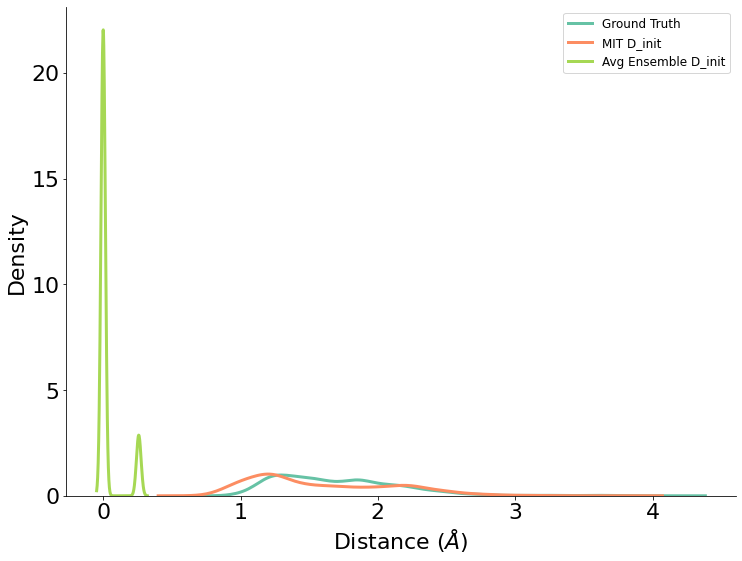

In [84]:
fig, ax = plt.subplots(figsize=(12,9))

num_to_plot = len(ds_dict)
cols = sns.color_palette("Set2", num_to_plot)

# keys: 'gt', 'lin_approx', 'best_init', f'D_init{i}'
no_print = ['lin_approx']
print_d_init = False
if not print_d_init:
    for j in range(1, num_d_inits + 1):
        no_print.append(f'D_init{j}')

for i, key in enumerate(ds_dict.keys()):
    if key in no_print:
        continue
    sns.distplot(ds_dict[key][0], color=cols[i], kde_kws={"lw": 3, "label": ds_dict[key][1]}, hist=False)

ax.legend(loc='upper right')
ax.legend(fontsize=12)
ax.set_ylabel('Density', fontsize=22)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True) 